In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time  # Import time module for tracking duration

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch_timings_pytorch=[]

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to a smaller size (64x64)
    transforms.Grayscale(num_output_channels=3),  # Convert 1 channel to 3 channels
    transforms.ToTensor(),          # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define a custom denser CNN model
class DenseCNN(nn.Module):
    def __init__(self):
        super(DenseCNN, self).__init__()
        # Convolutional layers with more filters
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels (RGB), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64 input channels, 128 output channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with kernel size 2x2
        
        # Fully connected layers with increased neurons
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Fully connected layer, increased neurons
        self.fc2 = nn.Linear(512, 256)          # Another fully connected layer
        self.fc3 = nn.Linear(256, 10)           # Output layer with 10 classes (for MNIST)

    def forward(self, x):
        # Apply convolutions -> ReLU -> Pooling
        x = self.pool(torch.relu(self.conv1(x)))  # Apply conv1 -> relu -> pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply conv2 -> relu -> pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Apply conv3 -> relu -> pooling
        
        x = x.view(-1, 128 * 8 * 8)  # Flatten the output from conv layers
        x = torch.relu(self.fc1(x))  # Fully connected layer 1 with relu activation
        x = torch.relu(self.fc2(x))  # Fully connected layer 2 with relu activation
        x = self.fc3(x)  # Output layer (no activation, CrossEntropyLoss handles it)
        return x

# Instantiate the model and move to device
model = DenseCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training and validation loop with time tracking
epochs = 100
total_start_time_pytorch=time.time() 
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    start_time = time.time()  # Start the timer

    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update metrics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    end_time = time.time()  # End the timer
    epoch_duration = end_time - start_time
    epoch_timings_pytorch.append(epoch_duration)
    print(f"Time taken for Epoch {epoch + 1}: {epoch_duration:.4f} seconds")
    
    
total_end_time_pytorch=time.time() 
total_train_time_pytorch=total_end_time_pytorch-total_start_time_pytorch
print()
print(f"TOTAL TIME TAKEN BY PYTORCH TO TRAIN THE MODEL IS ....{total_train_time_pytorch} SECONDS")


Epoch 1/100
Train Loss: 0.2264, Train Accuracy: 0.9308
Validation Loss: 0.0611, Validation Accuracy: 0.9790
Time taken for Epoch 1: 39.9118 seconds

Epoch 2/100
Train Loss: 0.0574, Train Accuracy: 0.9820
Validation Loss: 0.0424, Validation Accuracy: 0.9862
Time taken for Epoch 2: 27.3080 seconds

Epoch 3/100
Train Loss: 0.0363, Train Accuracy: 0.9886
Validation Loss: 0.0468, Validation Accuracy: 0.9858
Time taken for Epoch 3: 26.9509 seconds

Epoch 4/100
Train Loss: 0.0268, Train Accuracy: 0.9916
Validation Loss: 0.0333, Validation Accuracy: 0.9885
Time taken for Epoch 4: 27.4800 seconds

Epoch 5/100
Train Loss: 0.0188, Train Accuracy: 0.9940
Validation Loss: 0.0392, Validation Accuracy: 0.9875
Time taken for Epoch 5: 27.6795 seconds

Epoch 6/100
Train Loss: 0.0141, Train Accuracy: 0.9958
Validation Loss: 0.0277, Validation Accuracy: 0.9911
Time taken for Epoch 6: 27.0015 seconds

Epoch 7/100
Train Loss: 0.0112, Train Accuracy: 0.9961
Validation Loss: 0.0311, Validation Accuracy: 0.99

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import time

if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used.")
    gpus = tf.config.list_physical_devices('GPU')
else:
    print("GPU is not available. Ensure CUDA and cuDNN are properly installed.")

# Load MNIST dataset
epoch_timings_tensorflow=[]
ds, info = tfds.load("mnist", as_supervised=True, with_info=True)

# Use 60,000 images for training and 10,000 for validation
ds_train = ds['train'].take(60000)  # First 60,000 images for training
ds_val = ds['test'].take(10000)  # 10,000 images for testing/validation






def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]
    image = tf.image.resize(image, [64, 64])  # Resize images to 64x64
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB (3 channels)
    return image, label


batch_size = 32
ds_train = ds_train.map(preprocess).shuffle(10000).batch(batch_size)
ds_val = ds_val.map(preprocess).batch(batch_size)

# Define the model
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        self.dense3 = tf.keras.layers.Dense(10)  # Output layer with 10 classes (for MNIST)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

model = MNISTModel()

# Define loss and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Training loop
epochs = 100

total_start_time_tensorflow=time.time() 

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    start_time = time.time()  # Start the timer

    # Initialize metrics
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_loss = tf.keras.metrics.Mean()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training
    for step, (images, labels) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(images, training=True)  # Forward pass
            loss = loss_fn(labels, logits)        # Compute loss
        # Compute gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        # Apply gradients to update model parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Update metrics
        train_loss.update_state(loss)
        train_accuracy.update_state(labels, logits)

        # if step % 100 == 0:
        #     print(f"Step {step}, Loss: {loss.numpy():.4f}, Accuracy: {train_accuracy.result().numpy():.4f}")

    # Validation
    for val_images, val_labels in ds_val:
        val_logits = model(val_images, training=False)  # Forward pass
        val_loss.update_state(loss_fn(val_labels, val_logits))
        val_accuracy.update_state(val_labels, val_logits)

    # Epoch summary
   
    print(f"Train Loss: {train_loss.result().numpy():.4f}, Train Accuracy: {train_accuracy.result().numpy():.4f}")
    print(f"Validation Loss: {val_loss.result().numpy():.4f}, Validation Accuracy: {val_accuracy.result().numpy():.4f}")
    end_time = time.time()  # End the timer
    epoch_duration = end_time - start_time
    epoch_timings_tensorflow.append(epoch_duration)
    print(f"Time taken for Epoch {epoch + 1}: {epoch_duration:.4f} seconds")

total_end_time_tensorflow=time.time()

total_train_time_tensorflow=total_end_time_tensorflow-total_start_time_tensorflow
print()
print(f"TOTAL TIME TAKEN BY TENSORFLOW TO TRAIN THE MODEL IS ....{total_train_time_tensorflow} SECONDS")

2024-12-15 09:11:24.274467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 09:11:24.274607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 09:11:24.385921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 09:11:24.788495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 09:11:27.347109: W tensorflow/compiler/tf2

GPU is available and will be used.


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2024-12-15 09:11:32.807275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-15 09:11:32.807451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-15 09:11:32.807532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Epoch 1/100


2024-12-15 09:11:36.766762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-12-15 09:11:38.419710: I external/local_xla/xla/service/service.cc:168] XLA service 0x1304f67d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-15 09:11:38.419911: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-15 09:11:38.440415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734253898.575171      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Train Loss: 0.1122, Train Accuracy: 0.9653
Validation Loss: 0.0401, Validation Accuracy: 0.9879
Time taken for Epoch 1: 47.5502 seconds

Epoch 2/100
Train Loss: 0.0407, Train Accuracy: 0.9879
Validation Loss: 0.0538, Validation Accuracy: 0.9835
Time taken for Epoch 2: 43.2096 seconds

Epoch 3/100
Train Loss: 0.0291, Train Accuracy: 0.9918
Validation Loss: 0.0356, Validation Accuracy: 0.9891
Time taken for Epoch 3: 39.8141 seconds

Epoch 4/100
Train Loss: 0.0225, Train Accuracy: 0.9932
Validation Loss: 0.0413, Validation Accuracy: 0.9888
Time taken for Epoch 4: 40.6079 seconds

Epoch 5/100
Train Loss: 0.0168, Train Accuracy: 0.9950
Validation Loss: 0.0315, Validation Accuracy: 0.9905
Time taken for Epoch 5: 39.5436 seconds

Epoch 6/100
Train Loss: 0.0154, Train Accuracy: 0.9956
Validation Loss: 0.0411, Validation Accuracy: 0.9894
Time taken for Epoch 6: 40.5166 seconds

Epoch 7/100
Train Loss: 0.0129, Train Accuracy: 0.9962
Validation Loss: 0.0484, Validation Accuracy: 0.9890
Time taken

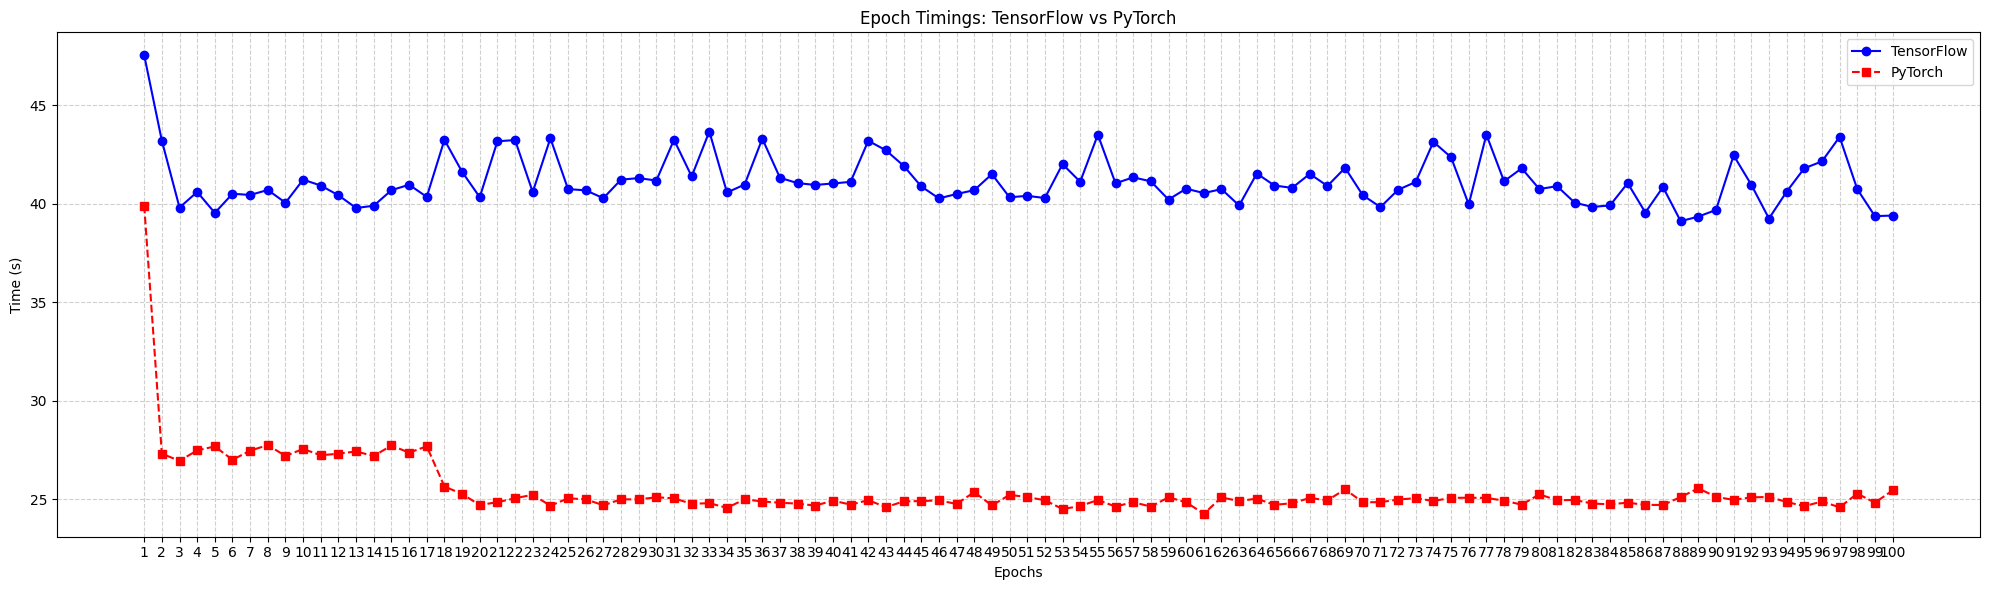

In [4]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(epoch_timings_tensorflow) + 1))  # Generate epoch numbers based on the timing arrays

# Plotting
plt.figure(figsize=(20, 6))

# Plot TensorFlow and PyTorch timings
plt.plot(epochs, epoch_timings_tensorflow, label="TensorFlow", marker='o', linestyle='-', color='b')
plt.plot(epochs, epoch_timings_pytorch, label="PyTorch", marker='s', linestyle='--', color='r')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Time (s)")
plt.title("Epoch Timings: TensorFlow vs PyTorch")
plt.xticks(epochs)  # Show epoch numbers on the x-axis
plt.legend()  # Add a legend
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid

# Show the plot
plt.tight_layout()
plt.show()
